In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/To The Moon - From Reddit Comments to Stocks/Code/LSTMR"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [ ]:
# Imports
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import gc
from IPython.display import display

# Sci-kit Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# NN
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding, Conv2D, MaxPooling2D

In [ ]:
# Load file
df = pd.read_csv("all_merged_sw.csv",
                 usecols=['post_id', 'date', 'num_comments', 'score', 'total_awards',
                          'author_commentkarma', 'compound_score', 'author_id', 'author_name',
                          'ticker', 'post_type', 'adjclose_20_X', 'adjclose_19_X', 'adjclose_18_X',
                          'adjclose_17_X', 'adjclose_16_X', 'adjclose_15_X', 'adjclose_14_X', 
                          'adjclose_13_X', 'adjclose_12_X', 'adjclose_11_X', 'adjclose_10_X',
                          'adjclose_9_X', 'adjclose_8_X', 'adjclose_7_X', 'adjclose_6_X',
                          'adjclose_5_X', 'adjclose_4_X', 'adjclose_3_X', 'adjclose_2_X',
                          'adjclose_1_X', 'adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                          'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y', 'adjclose_8_Y',
                          'adjclose_9_Y', 'adjclose_10_Y', 'adjclose_11_Y', 'adjclose_12_Y',
                          'adjclose_13_Y', 'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y',
                          'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y', 'adjclose_20_Y',
                          'adjclose_21_Y'])

df

,post_id,date,num_comments,score,total_awards,author_commentkarma,compound_score,author_id,author_name,ticker,post_type,adjclose_20_X,adjclose_19_X,adjclose_18_X,adjclose_17_X,adjclose_16_X,adjclose_15_X,adjclose_14_X,adjclose_13_X,adjclose_12_X,adjclose_11_X,adjclose_10_X,adjclose_9_X,adjclose_8_X,adjclose_7_X,adjclose_6_X,adjclose_5_X,adjclose_4_X,adjclose_3_X,adjclose_2_X,adjclose_1_X,adjclose_2_Y,adjclose_3_Y,adjclose_4_Y,adjclose_5_Y,adjclose_6_Y,adjclose_7_Y,adjclose_8_Y,adjclose_9_Y,adjclose_10_Y,adjclose_11_Y,adjclose_12_Y,adjclose_13_Y,adjclose_14_Y,adjclose_15_Y,adjclose_16_Y,adjclose_17_Y,adjclose_18_Y,adjclose_19_Y,adjclose_20_Y,adjclose_21_Y
0,ed1i6xt,2019-01-01,2,9,0.0,1855.0,0.2023,a36tf,gundeck925,CONE,comment,52.026543,51.579323,50.899178,51.113464,49.315266,49.231415,48.467411,50.414680,50.787373,49.864975,50.628979,50.535812,50.843269,51.076195,51.495464,51.365028,51.961319,52.138344,51.691128,50.321518,46.610138,47.982403,48.602737,49.740036,47.268070,48.790726,49.016304,48.593346,48.828323,48.865921,48.734329,49.016304,48.236179,46.995499,47.221077,46.967300,49.223080,49.345276,50.144196,50.943123
1,ed0rsq9,2019-01-01,1,3,0.0,8101.0,0.4588,54sdn,turbotoast,CACC,comment,410.399994,412.209991,403.850006,407.559998,402.260010,401.640015,394.000000,405.670013,422.100006,418.700012,414.880005,411.429993,410.630005,422.489990,425.000000,422.890015,416.989990,418.190002,423.570007,424.119995,395.029999,408.260010,406.559998,410.619995,410.309998,415.850006,422.600006,420.929993,413.359985,416.309998,421.739990,429.119995,424.959991,420.950012,405.570007,409.929993,411.890015,408.670013,414.369995,398.019989
2,ed149cc,2019-01-01,2,6,0.0,234162.0,-0.5106,6lvmmbl,Shmokesshweed,WSBC,comment,38.873425,39.189323,38.214558,38.683891,38.115276,38.187477,38.061119,38.268715,38.377018,38.286758,37.330048,37.781326,37.573742,37.727173,38.115276,37.799374,37.582760,37.212711,37.095379,36.598965,33.853710,34.880959,34.944592,35.153675,35.180950,35.135498,34.962769,34.917316,35.162773,35.871841,36.108204,36.135464,35.799118,35.417305,35.771847,36.090015,36.171829,37.799068,37.862701,36.917271
3,ed0rg2j,2019-01-01,9,6,0.0,744.0,0.3612,2dk1wq99,nightman_123,WSBC,comment,38.873425,39.189323,38.214558,38.683891,38.115276,38.187477,38.061119,38.268715,38.377018,38.286758,37.330048,37.781326,37.573742,37.727173,38.115276,37.799374,37.582760,37.212711,37.095379,36.598965,33.853710,34.880959,34.944592,35.153675,35.180950,35.135498,34.962769,34.917316,35.162773,35.871841,36.108204,36.135464,35.799118,35.417305,35.771847,36.090015,36.171829,37.799068,37.862701,36.917271
4,abjmvm,2019-01-01,34,10,0.0,744.0,-0.8442,2dk1wq99,nightman_123,WSBC,submission,38.873425,39.189323,38.214558,38.683891,38.115276,38.187477,38.061119,38.268715,38.377018,38.286758,37.330048,37.781326,37.573742,37.727173,38.115276,37.799374,37.582760,37.212711,37.095379,36.598965,33.853710,34.880959,34.944592,35.153675,35.180950,35.135498,34.962769,34.917316,35.162773,35.871841,36.108204,36.135464,35.799118,35.417305,35.771847,36.090015,36.171829,37.799068,37.862701,36.917271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940780,ghmym1x,2020-12-31,1,8,0.0,4431.0,0.4939,vh0ilgz,MerganzerMunson,ADES,comment,5.650000,6.020000,5.830000,6.150000,5.700000,5.500000,5.260000,5.240000,5.240000,5.170000,4.980000,4.880000,4.980000,4.940000,4.720000,4.500000,4.580000,4.510000,4.600000,4.560000,5.370000,5.450000,5.560000,5.570000,5.490000,5.330000,5.530000,5.400000,5.520000,5.500000,5.420000,5.450000,5.330000,5.380000,5.440000,5.500000,5.250000,5.190000,5.070000,5.120000
940781,ghmym1x,2020-12-31,1,8,0.0,4431.0,0.4939,vh0ilgz,MerganzerMunson,JAN,comment,4.270000,4.500000,4.620000,4.510000,4.590000,4.440000,4.330000,4.200000,4.330000,4.240000,4.080000,4.050000,4.080000,3.900000,3.890000,3.800000,3.850000,3.680000,3.680000,3.5

In [ ]:
# Print the colum names
df.columns.values

array(['post_id', 'date', 'num_comments', 'score', 'total_awards',
       'author_commentkarma', 'compound_score', 'author_id',
       'author_name', 'ticker', 'post_type', 'adjclose_20_X',
       'adjclose_19_X', 'adjclose_18_X', 'adjclose_17_X', 'adjclose_16_X',
       'adjclose_15_X', 'adjclose_14_X', 'adjclose_13_X', 'adjclose_12_X',
       'adjclose_11_X', 'adjclose_10_X', 'adjclose_9_X', 'adjclose_8_X',
       'adjclose_7_X', 'adjclose_6_X', 'adjclose_5_X', 'adjclose_4_X',
       'adjclose_3_X', 'adjclose_2_X', 'adjclose_1_X', 'adjclose_2_Y',
       'adjclose_3_Y', 'adjclose_4_Y', 'adjclose_5_Y', 'adjclose_6_Y',
       'adjclose_7_Y', 'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
       'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y', 'adjclose_14_Y',
       'adjclose_15_Y', 'adjclose_16_Y', 'adjclose_17_Y', 'adjclose_18_Y',
       'adjclose_19_Y', 'adjclose_20_Y', 'adjclose_21_Y'], dtype=object)

In [ ]:
# Find the min and max at 1-4 business week intervals
df['5day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y']].idxmin(axis=1)

df['10day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y']].idxmin(axis=1)

df['15day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y']].idxmin(axis=1)

df['20day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y',
                      'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y',
                      'adjclose_20_Y', 'adjclose_21_Y']].idxmin(axis=1)

df['5day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y']].idxmax(axis=1)

df['10day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y']].idxmax(axis=1)

df['15day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y']].idxmax(axis=1)

df['20day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y',
                      'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y',
                      'adjclose_20_Y', 'adjclose_21_Y']].idxmax(axis=1)

# Extract the day number and convert to int
df['5day_min'] = df['5day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['10day_min'] = df['10day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['15day_min'] = df['15day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['20day_min'] = df['20day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['5day_max'] = df['5day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['10day_max'] = df['10day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['15day_max'] = df['15day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['20day_max'] = df['20day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)

In [ ]:
# Get the X-variable columns
df_X = df[['num_comments', 'score', 'total_awards', 'author_commentkarma',
           'compound_score', 'adjclose_20_X', 'adjclose_19_X', 'adjclose_18_X',
           'adjclose_17_X', 'adjclose_16_X', 'adjclose_15_X', 'adjclose_14_X',
           'adjclose_13_X', 'adjclose_12_X', 'adjclose_11_X', 'adjclose_10_X',
           'adjclose_9_X', 'adjclose_8_X', 'adjclose_7_X', 'adjclose_6_X',
           'adjclose_5_X', 'adjclose_4_X', 'adjclose_3_X', 'adjclose_2_X',
           'adjclose_1_X']]

# Get the Y-variable columns
df_Y = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y', 'adjclose_5_Y',
           'adjclose_6_Y', 'adjclose_7_Y', 'adjclose_8_Y', 'adjclose_9_Y',
           'adjclose_10_Y', 'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
           'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y', 'adjclose_17_Y',
           'adjclose_18_Y', 'adjclose_19_Y', 'adjclose_20_Y', 'adjclose_21_Y',
           '5day_min', '10day_min', '15day_min', '20day_min', '5day_max',
           '10day_max', '15day_max', '20day_max']]

# Clear up memory
del df
gc.collect()

# Get 80% of the data by date
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2,
                                                    shuffle=False)

# Print
print(X_train)
print(X_test)
print(y_train)
print(y_test)

        num_comments  score  ...  adjclose_2_X  adjclose_1_X
0                  2      9  ...     51.691128     50.321518
1                  1      3  ...    423.570007    424.119995
2                  2      6  ...     37.095379     36.598965
3                  9      6  ...     37.095379     36.598965
4                 34     10  ...     37.095379     36.598965
...              ...    ...  ...           ...           ...
752623             0     22  ...     22.115402     21.883425
752624             1     42  ...     22.115402     21.883425
752625             1     22  ...    127.827332    128.855957
752626            51    115  ...     21.590000     24.350000
752627            51    115  ...      7.080000      6.700000

[752628 rows x 25 columns]
        num_comments  score  ...  adjclose_2_X  adjclose_1_X
752628             0      8  ...      4.360000      4.350000
752629             1     10  ...     22.115402     21.883425
752630             0      3  ...      2.060000      2.110

In [ ]:
print(X_train.shape)
print(X_test.shape)
red_train = X_train[['num_comments', 'score', 'total_awards', 'author_commentkarma',
           'compound_score']].to_numpy()

print(red_train.shape)


red_test = X_test[['num_comments', 'score', 'total_awards', 'author_commentkarma',
           'compound_score']].to_numpy()
print(red_test.shape)

X_train = X_train.drop(columns = ['num_comments', 'score', 'total_awards', 'author_commentkarma',
           'compound_score']).to_numpy()
print(X_train.shape)

X_test = X_test.drop(columns = ['num_comments', 'score', 'total_awards', 'author_commentkarma',
           'compound_score']).to_numpy()
print(X_test.shape)

(752628, 25)
(188157, 25)
(752628, 5)
(188157, 5)
(752628, 20)
(188157, 20)


In [ ]:
# Normalize data
scaler = MinMaxScaler()

n_features = 5

print(scaler.fit(X_train))
xtrain_scale=scaler.transform(X_train)

#xtrain_scale = xtrain_scale.reshape(xtrain_scale.shape[0], xtrain_scale.shape[1], n_features)
xtrain_scale = xtrain_scale.reshape(xtrain_scale.shape[0], 4, n_features)

print(scaler.fit(X_test))
xval_scale=scaler.transform(X_test)
#xval_scale = xval_scale.reshape(xval_scale.shape[0], xval_scale.shape[1], n_features)
xval_scale = xval_scale.reshape(xval_scale.shape[0], 4, n_features)

print(scaler.fit(red_train))
red_train_scale = scaler.transform(red_train)
print(scaler.fit(red_test))
red_test_scale = scaler.transform(red_test)

print(scaler.fit(y_train))
ytrain_scale=scaler.transform(y_train)

print(scaler.fit(y_test))
yval_scale=scaler.transform(y_test)

# Set input and output dimensions
indim = xtrain_scale.shape[1]
outdim = ytrain_scale.shape[1]

#this dimension is for reddit data
input_dim = red_train_scale.shape[1]

# Predict
#ypred = model.predict(xval_scale)

# Scale back to original scale
#ypred = scaler.inverse_transform(ypred)

MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

def create_mlp():
    model = Sequential()
    model.add(Dense(input_dim+1, input_dim=input_dim))
    # Hidden layer with ~sqrt(X_train.shape[0] = sqrt(188157))
    model.add(Dense(434))
    model.add(Dropout(0.2))
    return model

def create_lstm():
    model = Sequential()
    # First LSTM layer with Dropout regularisation
    model.add(LSTM(units=50, return_sequences=True, input_shape=(indim, n_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False, input_shape=(indim, n_features)))
    model.add(Dropout(0.2))
    # Output layer
    #model.add(Dense(434))
    return model

In [ ]:
input_dim

5

In [ ]:
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model

mlp = create_mlp()
lstm = create_lstm()
combinedInput = Concatenate(axis=1)([mlp.output, lstm.output])
x = Dense(outdim)(combinedInput)
model = Model(inputs=[mlp.input, lstm.input], outputs=x)
model.compile(optimizer='rmsprop', loss='mse', metrics=['mse', 'mae'])

model.fit(x=[red_train_scale, xtrain_scale], y=ytrain_scale, epochs=10, batch_size=128, verbose = 0)

ypred = model.predict([red_test_scale,xval_scale])

# Scale back to original scale
ypred = scaler.inverse_transform(ypred)

In [ ]:
# Evaluate RMSE
rmse = mean_squared_error(y_test, ypred, multioutput='raw_values', squared=False)

# For each value in rmse
for i in range(1, len(rmse)+1):

    # Print the RMSE values for adjClose
    if i < 21:
        print("The RMSE for adjClose_{}_Y = ".format(i+1), rmse[i-1]**0.5)

    # Print the RMSE values for min day
    elif 21 <= i < 25:
        print("The RMSE for {}day_min = ".format((i-20)*5), rmse[i-1]**0.5)

    # Print the RMSE for max day
    else:
        print("The RMSE for {}day_max = ".format((i-24)*5), rmse[i-1]**0.5)

The RMSE for adjClose_2_Y =  44.01489018016152
The RMSE for adjClose_3_Y =  44.79883093213086
The RMSE for adjClose_4_Y =  46.39969970484777
The RMSE for adjClose_5_Y =  47.55541697917551
The RMSE for adjClose_6_Y =  50.42582946528338
The RMSE for adjClose_7_Y =  52.511232607665235
The RMSE for adjClose_8_Y =  54.807649979746856
The RMSE for adjClose_9_Y =  56.47170100785106
The RMSE for adjClose_10_Y =  56.47280314802943
The RMSE for adjClose_11_Y =  56.645728766667354
The RMSE for adjClose_12_Y =  59.28650039180131
The RMSE for adjClose_13_Y =  62.56875829275634
The RMSE for adjClose_14_Y =  64.04828464230836
The RMSE for adjClose_15_Y =  66.51865128737673
The RMSE for adjClose_16_Y =  66.93880740845623
The RMSE for adjClose_17_Y =  68.64199594743718
The RMSE for adjClose_18_Y =  69.72886040876419
The RMSE for adjClose_19_Y =  71.4047696637567
The RMSE for adjClose_20_Y =  70.70335353994965
The RMSE for adjClose_21_Y =  74.73367568890656
The RMSE for 5day_min =  1.5743849078272634
Th

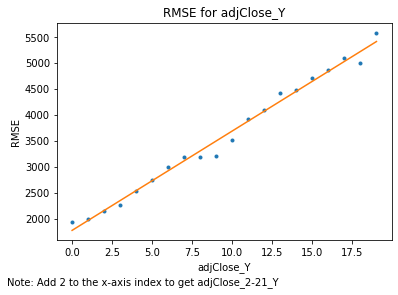

In [ ]:
# Plot the RMSE for adjClose
x = np.arange(20)
y = rmse[0:20]

# Fit with polyfit
b, m = polyfit(x, y, 1)

# Add title and axis names
plt.title('RMSE for adjClose_Y')
plt.xlabel('adjClose_Y')
plt.ylabel('RMSE')

# Add a footnote below and to the left side of the chart
plt.figtext(0.01, -0.03,
            'Note: Add 2 to the x-axis index to get adjClose_2-21_Y',
            horizontalalignment='left')

plt.plot(x, y, '.')
plt.plot(x, m*x+b, '-')
plt.show()

In [ ]:
# Evaluate MAE
mae = mean_absolute_error(y_test, ypred, multioutput='raw_values')

# For each value in rmse
for i in range(1, len(mae)+1):

    # Print the RMSE values for adjClose
    if i < 21:
        print("The MAE for adjClose_{}_Y = ".format(i+1), mae[i-1])

    # Print the RMSE values for min day
    elif 21 <= i < 25:
        print("The MAE for {}day_min = ".format((i-20)*5), mae[i-1])

    # Print the RMSE for max day
    else:
        print("The MAE for {}day_max = ".format((i-24)*5), mae[i-1])

The MAE for adjClose_2_Y =  19.400763352522084
The MAE for adjClose_3_Y =  20.302952128341648
The MAE for adjClose_4_Y =  20.09888736073217
The MAE for adjClose_5_Y =  20.1844118092463
The MAE for adjClose_6_Y =  20.50425944083402
The MAE for adjClose_7_Y =  22.158948513033966
The MAE for adjClose_8_Y =  22.91079873436569
The MAE for adjClose_9_Y =  23.327125939046905
The MAE for adjClose_10_Y =  22.530155962123185
The MAE for adjClose_11_Y =  22.537655225492077
The MAE for adjClose_12_Y =  23.15001016133687
The MAE for adjClose_13_Y =  23.457760286337464
The MAE for adjClose_14_Y =  23.915996378011133
The MAE for adjClose_15_Y =  24.924020609922923
The MAE for adjClose_16_Y =  25.536896029846314
The MAE for adjClose_17_Y =  26.540645009585198
The MAE for adjClose_18_Y =  26.162030852342216
The MAE for adjClose_19_Y =  26.664342802493753
The MAE for adjClose_20_Y =  26.9500998279998
The MAE for adjClose_21_Y =  29.19796237297851
The MAE for 5day_min =  1.397354943043953
The MAE for 10d

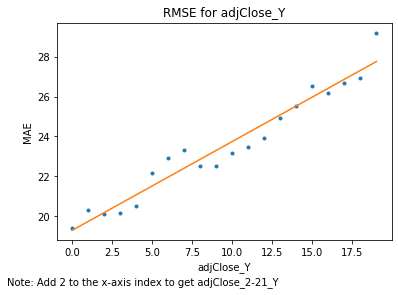

In [ ]:
# Plot the MAE for adjClose
x = np.arange(20)
y = mae[0:20]

# Fit with polyfit
b, m = polyfit(x, y, 1)

# Add title and axis names
plt.title('RMSE for adjClose_Y')
plt.xlabel('adjClose_Y')
plt.ylabel('MAE')

# Add a footnote below and to the left side of the chart
plt.figtext(0.01, -0.03,
            'Note: Add 2 to the x-axis index to get adjClose_2-21_Y',
            horizontalalignment='left')

plt.plot(x, y, '.')
plt.plot(x, m*x+b, '-')
plt.show()

# Get last 20% of rows
tail = df.tail(188157)

# Reset index
tail.reset_index(drop=True, inplace=True)

# Merge predictions with original data frame
df = pd.concat([tail, pd.DataFrame(ypred)], axis=1, ignore_index=True)

# Rename columns
df.columns = ['post_id', 'date', 'num_comments', 'score', 'total_awards',
              'author_commentkarma', 'compound_score', 'author_id', 'author_name',
              'ticker', 'post_type', 'adjclose_20_X', 'adjclose_19_X', 'adjclose_18_X',
              'adjclose_17_X', 'adjclose_16_X', 'adjclose_15_X', 'adjclose_14_X',
              'adjclose_13_X', 'adjclose_12_X', 'adjclose_11_X', 'adjclose_10_X',
              'adjclose_9_X', 'adjclose_8_X', 'adjclose_7_X', 'adjclose_6_X',
              'adjclose_5_X', 'adjclose_4_X', 'adjclose_3_X', 'adjclose_2_X',
              'adjclose_1_X', 'adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
              'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y', 'adjclose_8_Y',
              'adjclose_9_Y', 'adjclose_10_Y', 'adjclose_11_Y', 'adjclose_12_Y',
              'adjclose_13_Y', 'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y',
              'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y', 'adjclose_20_Y',
              'adjclose_21_Y', 'pred_adjClose_2_Y', 'pred_adjClose_3_Y',
              'pred_adjClose_4_Y', 'pred_adjClose_5_Y', 'pred_adjClose_6_Y',
              'pred_adjClose_7_Y', 'pred_adjClose_8_Y', 'pred_adjClose_9_Y',
              'pred_adjClose_10_Y', 'pred_adjClose_11_Y', 'pred_adjClose_12_Y',
              'pred_adjClose_13_Y', 'pred_adjClose_14_Y', 'pred_adjClose_15_Y',
              'pred_adjClose_16_Y', 'pred_adjClose_17_Y', 'pred_adjClose_18_Y',
              'pred_adjClose_19_Y', 'pred_adjClose_20_Y', 'pred_adjClose_21_Y',
              'pred_5day_min', 'pred_10day_min', 'pred_15day_min', 'pred_20day_min',
              'pred_5day_max', 'pred_10day_max', 'pred_15day_max', 'pred_20day_max']

df

df.to_csv("red_fin_preds.csv", index=False)